# **Data Preparation**

In [51]:
# Importing Libraries
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# Loading dataset
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data cleanup 
df['job_posted_date'] = pd.to_datetime(df['job_posted_date']) #convert from str to datetime dtype
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x) #convert str to list


In [35]:
df['job_title_short'].unique().tolist()

['Senior Data Engineer',
 'Data Analyst',
 'Data Engineer',
 'Business Analyst',
 'Data Scientist',
 'Machine Learning Engineer',
 'Senior Data Analyst',
 'Cloud Engineer',
 'Senior Data Scientist',
 'Software Engineer']

In [36]:
df.describe()

,job_posted_date,salary_year_avg,salary_hour_avg
count,785741,22003.000000,10662.000000
mean,2023-06-25 16:02:11.860248576,123286.274072,47.016598
min,2023-01-01 00:00:04,15000.000000,8.000000
25%,2023-03-20 10:05:48,90000.000000,27.500000
50%,2023-06-29 06:11:38,115000.000000,45.980000
75%,2023-09-27 01:01:16,150000.000000,61.159996
max,2023-12-31 23:59:58,960000.000000,391.000000
std,NaN,48312.449482,21.890738


# **1-Job Title**

## **Top Job Title based on Number of Posts**

In [37]:
df_plot = df['job_title_short'].value_counts().to_frame(name='no_of_post')

# Create list of data-related job titles
data_jobs = [
    'Data Analyst','Data Scientist','Data Engineer','Senior Data Analyst',
    'Senior Data Scientist', 'Senior Data Engineer'
]

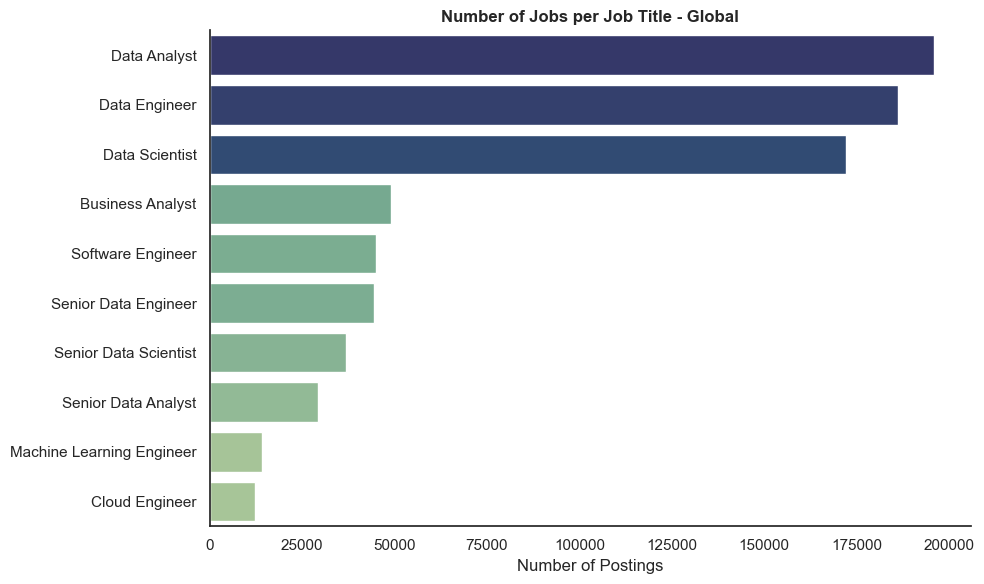

In [38]:
#Config
sns.set_theme(style="white", palette="viridis_r")
plt.figure(figsize=(10, 6))

# Plot chart
sns.barplot(
    data=df_plot, 
    x='no_of_post', 
    y='job_title_short', 
    hue='no_of_post',
    legend=False,
    palette='crest'
)

# Customize chart
plt.title('Number of Jobs per Job Title - Global', fontweight='bold')
plt.xlabel('Number of Postings')
plt.ylabel('')
sns.despine()
plt.tight_layout()

## **Job Posting Trend**

In [52]:
# Define list of data-related jobs
data_jobs = ['Data Analyst', 'Data Scientist', 'Data Engineer']

# Count by job titles and month
df_plot = (
    df[df['job_title_short'].isin(data_jobs)]
    .assign(job_posted_month=df['job_posted_date'].dt.month) # create month column
    .groupby(['job_title_short','job_posted_month']).size()
    .reset_index(name='count')
)

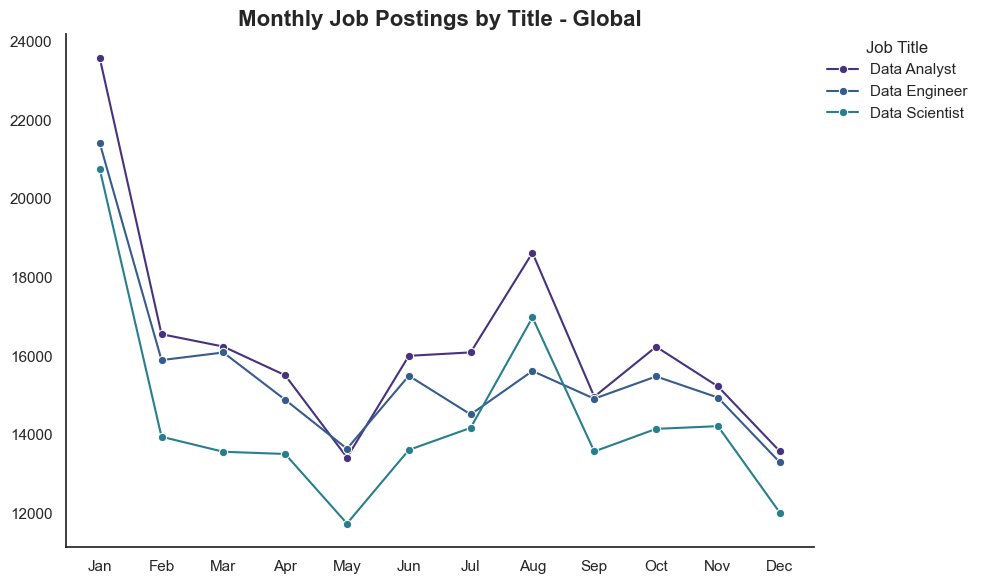

In [53]:
# Config
plt.figure(figsize=(10,6))
sns.set_theme(style="white", palette="viridis")

# Plot chart
sns.lineplot(
    data = df_plot,
    x = 'job_posted_month',
    y = 'count',
    hue='job_title_short',
    marker = 'o'
)

# Customize plot
plt.title('Monthly Job Postings by Title - Global', fontweight='bold',fontsize=16)

# Axis
plt.xlabel('')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('')
plt.legend(title='Job Title', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.tight_layout()
sns.despine()


# **2-Skill Analysis**

**Questions to be answered:**
- What are the skills most in demand for top 3 most popular data jobs?
- How are those required skills evolving over time?



## **Skill Prevalence**

In [54]:
# Break down job_skills from list into row
df_skill= df.explode('job_skills')
df_skill[['job_title_short','job_title','job_skills']]

# Count occurence of each skill by job title
df_skill_count = df_skill.groupby(['job_skills','job_title_short']).size()

# Convert result from Series to Dataframe
df_skill_count = df_skill_count.reset_index(name='skill_count')

# Sort skill count desc
df_skill_count.sort_values(by='skill_count',ascending=False,inplace=True)
df_skill_count

# Filter most popular job_title
top_job_title = df_skill_count['job_title_short'].unique().tolist()
top_job_title = sorted(top_job_title[:3])
top_job_title

# Count no of occurence of each job titles
df_job_title_count = df['job_title_short'].value_counts().reset_index(name='job_title_count')
df_job_title_count


# Merge df_job_title_count and df_skill_count
df_skill_perc = pd.merge(df_skill_count,df_job_title_count,on='job_title_short',how='left')

# Calculate the percentage of each skill within its job title 
df_skill_perc['skill_perc'] = (df_skill_perc['skill_count']/ df_skill_perc['job_title_count']) * 100
df_skill_perc

,job_skills,job_title_short,skill_count,job_title_count,skill_perc
0,python,Data Scientist,113711,172286,66.001300
1,sql,Data Engineer,113130,186241,60.743875
2,python,Data Engineer,108022,186241,58.001192
3,sql,Data Analyst,92428,196075,47.139105
4,sql,Data Scientist,78982,172286,45.843539
...,...,...,...,...,...
2251,webex,Senior Data Scientist,1,36957,0.002706
2252,codecommit,Business Analyst,1,49063,0.002038
2253,xamarin,Machine Learning Engineer,1,14080,0.007102
2254,mlr,Machine Learning Engineer,1,14080,0.007102


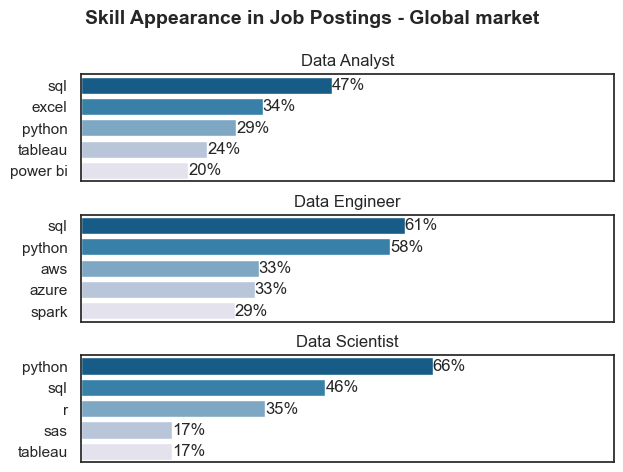

<Figure size 640x480 with 0 Axes>

In [55]:
# Config
fig,ax = plt.subplots(len(top_job_title),1)
sns.set_theme(style="white", palette="crest")

for i, job_title in enumerate(top_job_title):
    df_plot = df_skill_perc[df_skill_perc['job_title_short'] == job_title].head(5)
    sns.barplot(
        data=df_plot, 
        x='skill_perc', 
        y='job_skills', 
        ax=ax[i], 
        hue='skill_count',
        palette=sns.color_palette("PuBu", n_colors=5)
    )
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 100)
    
    ## remove the x-axis tick labels
    if i != len(job_title) - 1:
        ax[i].set_xticks([])
    
    ## Label percentage of each skill
    for index, perc in enumerate(df_plot['skill_perc']):
         ax[i].text(perc, index, f'{perc:.0f}%', va='center', ha='left')  


#Layout
fig.suptitle('Skill Appearance in Job Postings - Global market', fontsize=14, fontweight='bold')
fig.tight_layout(h_pad=.8)
plt.show()
plt.tight_layout()



## **Skill Trend Over Time**

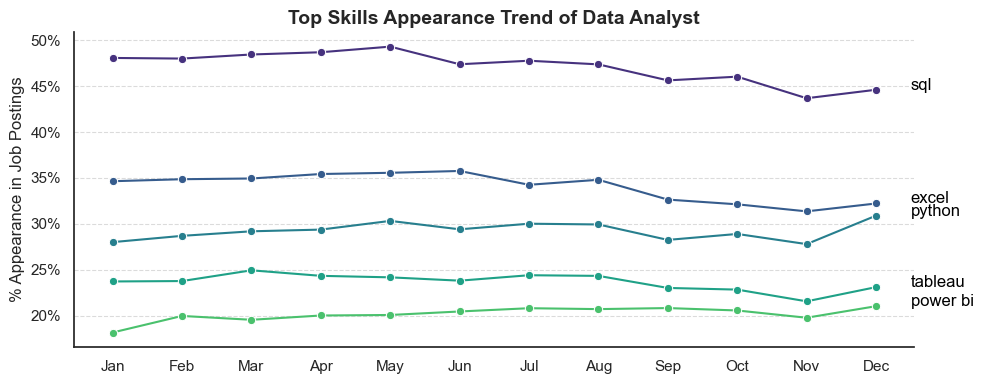

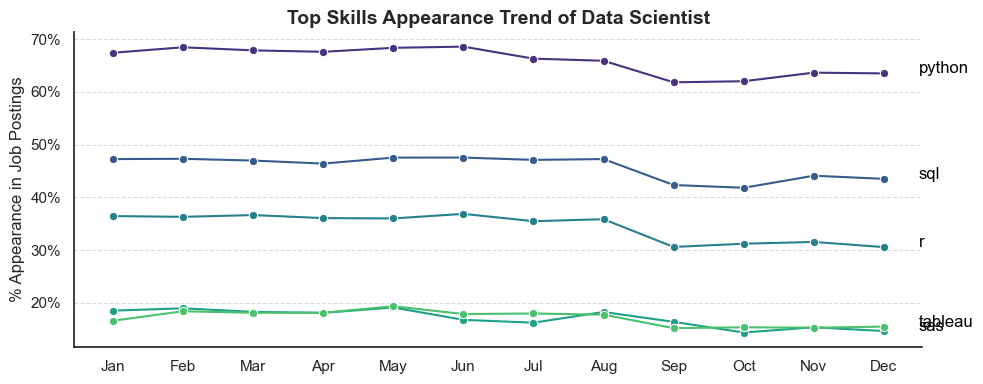

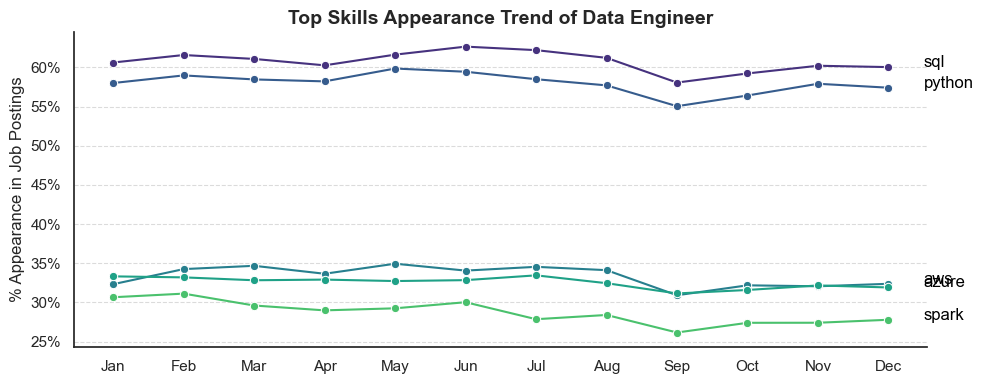

In [56]:
from matplotlib.ticker import PercentFormatter

# Filter roles
data_jobs = ['Data Analyst', 'Data Scientist', 'Data Engineer']

# Create month column
df['job_posted_month'] = df['job_posted_date'].dt.month

# Loop through data job roles
for role in data_jobs:
    # Filter for role
    df_role = df[df['job_title_short'] == role].copy()
    
    # Check if df_role is empty
    if df_role.empty:
        print(f'No data available for role: {role}')
        continue

    # Explode skills
    df_explode = df_role.explode('job_skills')

    # Check if df_explode is empty
    if df_explode.empty:
        print(f'No skills data available for role: {role}')
        continue

    # Pivot table: skill count by month
    df_pivot = df_explode.pivot_table(
        index='job_posted_month',
        columns='job_skills',
        aggfunc='size',
        fill_value=0
    )

    # Sort skill columns by total count
    df_pivot.loc['Column total'] = df_pivot.sum(axis=0)
    df_pivot = df_pivot[df_pivot.loc['Column total'].sort_values(ascending=False).index]
    df_pivot = df_pivot.drop('Column total')

    # Total job postings per month
    df_total = df_role.groupby('job_posted_month').size()

    # Percentage appearance of each skill
    df_perc = df_pivot.div(df_total / 100, axis=0)

    # Get top 5 skills
    df_plot = df_perc.iloc[:, :5]

    # Plot config
    sns.set_theme(style="white", palette="viridis")
    plt.figure(figsize=(10, 4))
    
    sns.lineplot(data=df_plot, marker='o', dashes=False)

    plt.title(f'Top Skills Appearance Trend of {role}', fontweight='bold', fontsize=14)
    plt.legend().remove()
    plt.xlabel('')
    plt.ylabel('% Appearance in Job Postings', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))
    plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.7)

    # Label lines
    for i in range(5):
        plt.text(12.5, df_plot.iloc[-1, i], df_plot.columns[i], color='black')

    plt.tight_layout()
    sns.despine()
    plt.show()


# **3-Salary Analysis**

**QnS to be answered:**
- Evaluate median salary for top 6 data jobs
- Find median salary per skill for Data Analysts
- Visualize for highest paying skills and most demanded skills

## **Salary Distribution**

In [44]:
# Drop N/A in salary_year_avg column 
df_salary = df.dropna(subset=['salary_year_avg']).copy()

In [45]:
# Create list of data job 
data_jobs = ['Data Analyst', 'Data Scientist','Data Engineer']

# Filter dataframe of data job 
df_plot = df_salary[df_salary['job_title_short'].isin(data_jobs)] 

# Sort job titles by median salary
job_order = df_plot.groupby('job_title_short')['salary_year_avg'].median().sort_values(ascending=False).index
job_order


Index(['Data Scientist', 'Data Engineer', 'Data Analyst'], dtype='object', name='job_title_short')

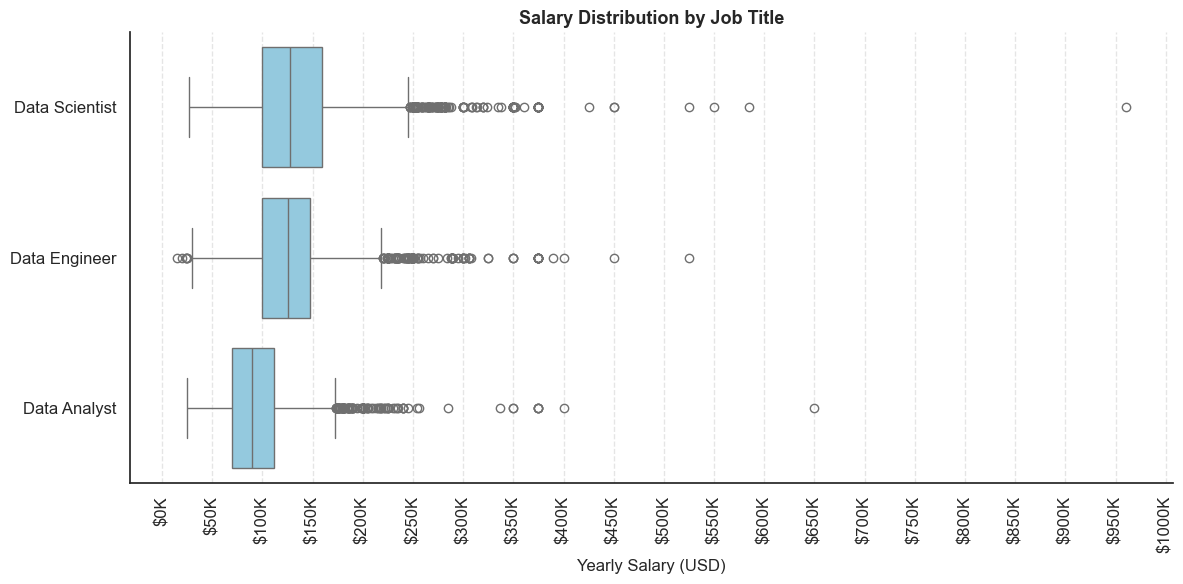

In [46]:
# Config
plt.figure(figsize=(12, 6))
sns.set_theme(style="white", palette="crest")

# Plot boxplot
sns.boxplot(
    data=df_plot,
    x='salary_year_avg',
    y='job_title_short',
    order=job_order,
    color='skyblue'
)

# Customize chart
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.title("Salary Distribution by Job Title", fontsize=13, weight='bold')
plt.xlabel('Yearly Salary (USD)')
plt.ylabel('')
# plt.gca().xaxis.set_major_formatter(ticks_x)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

# Set x-axis ticks at $50K intervals
min_salary = df_plot['salary_year_avg'].min()
max_salary = df_plot['salary_year_avg'].max()
xticks = np.arange(0, max_salary + 50000, 50000)
plt.xticks(xticks)

# Formatter (already in your code)
ticks_x = plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
plt.gca().xaxis.set_major_formatter(ticks_x)



plt.tight_layout()
sns.despine()

## **Median Salary by Skills**

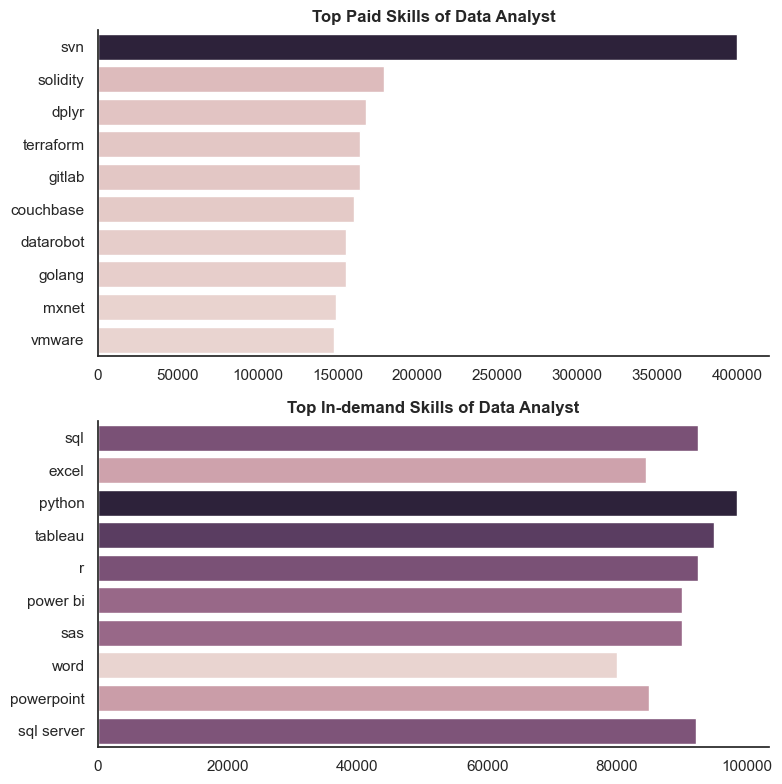

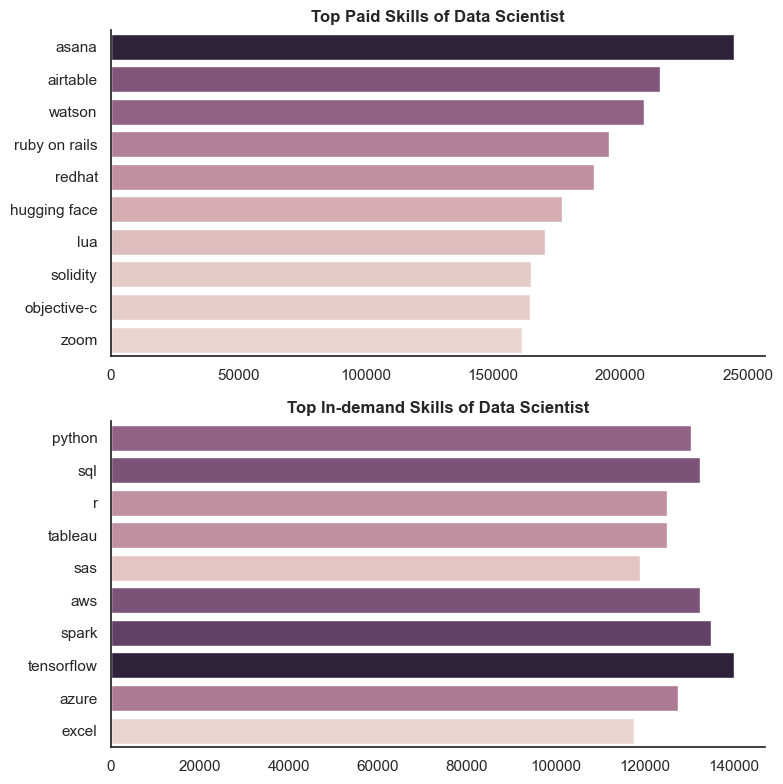

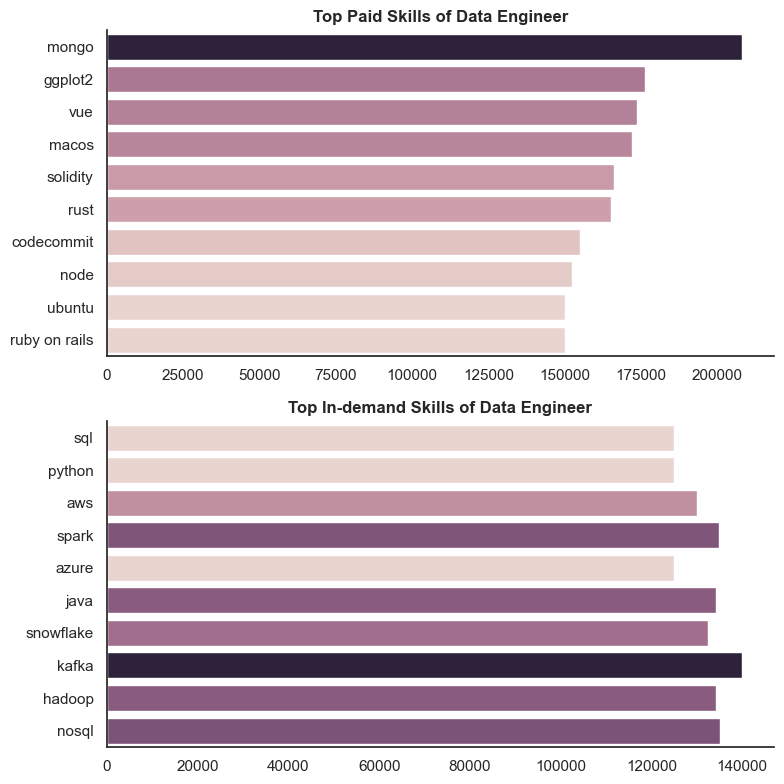

In [63]:
from matplotlib.ticker import FuncFormatter

# Create list of data jobs
data_jobs = ['Data Analyst', 'Data Scientist', 'Data Engineer']

# Set plot style
sns.set_theme(style="white", palette="crest")

for job in data_jobs:
    # Filter data job & explode job skills
    df_filter = df_salary[df_salary['job_title_short'] == job].copy()
    df_explode = df_filter.explode('job_skills')

    # Calculate top demand and paid skills
    df_top_demand = (df_explode.groupby('job_skills')['salary_year_avg']
                     .agg(['count', 'median'])
                     .sort_values('count', ascending=False)
                     .head(10))
                     
    df_top_paid = (df_explode.groupby('job_skills')['salary_year_avg']
                   .agg(['count', 'median'])
                   .sort_values('median', ascending=False)
                   .head(10))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

    # Plot highest paid skills
    plot1 = sns.barplot(data=df_top_paid, x='median', y=df_top_paid.index, hue='median', ax=ax1)
    ax1.set_title(f'Top Paid Skills of {job}', fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # for container in plot1.containers:
    #     ax1.bar_label(container, fmt='%.0f')  # Add value labels
    if ax1.get_legend():
        ax1.get_legend().remove()
   


    # Plot top in-demand skills
    plot2 = sns.barplot(data=df_top_demand, x='median', y=df_top_demand.index, hue='median', ax=ax2)
    ax2.set_title(f'Top In-demand Skills of {job}', fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    # for container in plot2.containers:
    #     ax2.bar_label(container, fmt='%.0f')  # Add value labels
    if ax2.get_legend():
        ax2.get_legend().remove()

    plt.tight_layout()
    sns.despine()

In [ ]:
# from matplotlib.ticker import FuncFormatter

# # Create list of data jobs
# data_jobs = ['Data Analyst', 'Data Scientist','Data Engineer']

# # Set plot style
# sns.set_theme(style="white", palette="crest_r")

# for job in data_jobs:
#     # Calculate top skills by demand
#     df_explode = df_salary[df_salary['job_title_short'] == job].explode('job_skills')
#     df_skills = (df_explode.groupby('job_skills')['salary_year_avg']
#                 .agg(['count', 'median'])
#                 .sort_values('count', ascending=False)
#                 .head(10))

#     # Create plot with dual axes    
#     fig, ax1 = plt.subplots(figsize=(12, 6))
#     ax2 = ax1.twinx()

#     # Plot number of job postings (bar)
#     sns.barplot(data=df_skills, x=df_skills.index, y='count', ax=ax1, color='skyblue', alpha=0.6, label='Job Postings')

#     ax1.set_ylabel('Number of Postings')
#     ax1.set_ylim(0, df_skills['count'].max() * 1.2)

#     # Plot median salary (line)
#     sns.lineplot(data=df_skills, x=df_skills.index, y='median', ax=ax2, color='darkred', marker='o', label='Median Salary')
#     ax2.set_ylabel('Median Salary')
#     ax2.set_ylim(0, df_skills['median'].max() * 1.2)

#     # Customize chart
#     ax1.set_title(f'Top Skills for {job}: Postings and Salary', fontweight='bold')
#     ax1.set_xlabel('')
#     plt.xticks(rotation=90, ha='center')
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')
#     plt.tight_layout()
#     sns.despine()

## **Median Salary by % Skills Prevalence**

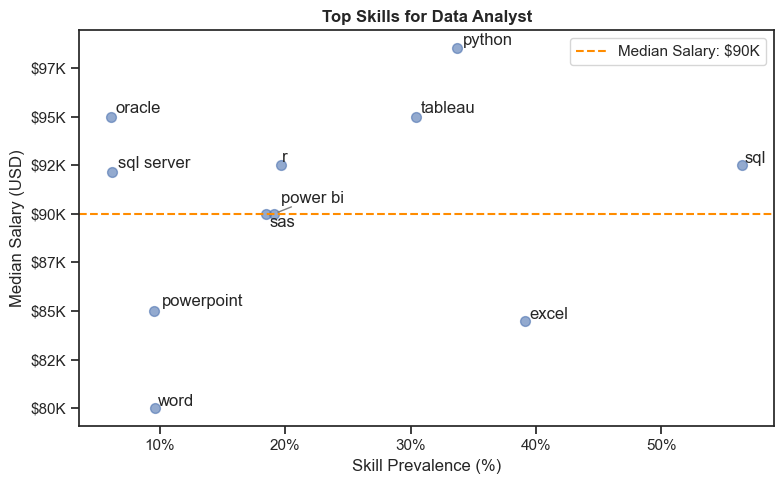

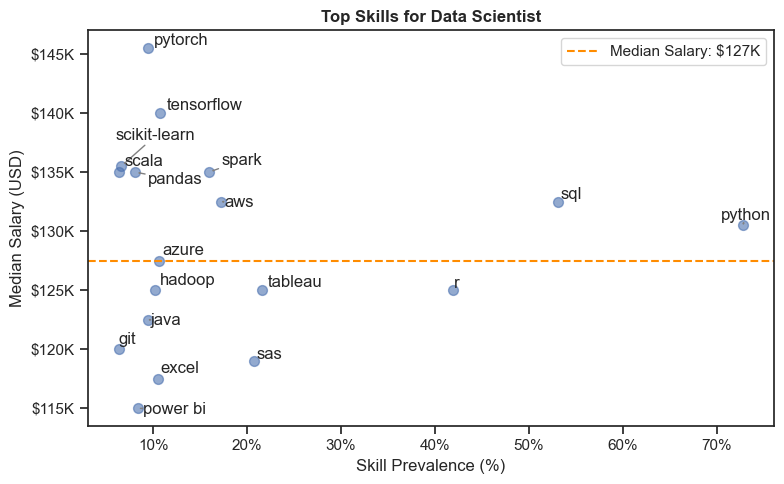

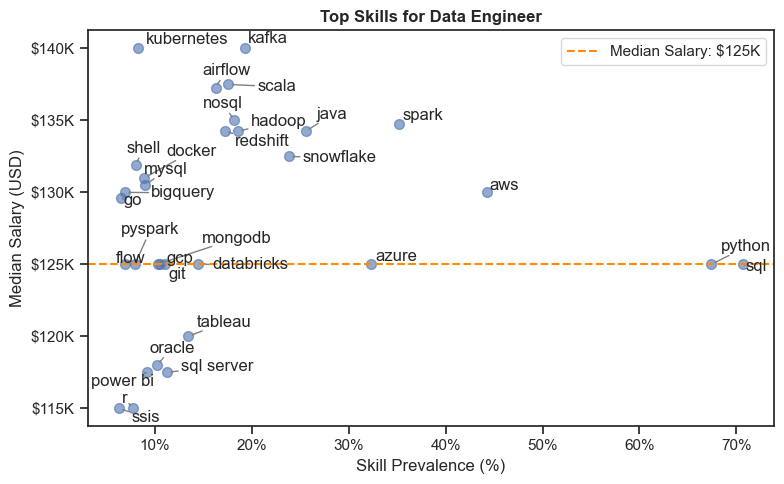

In [ ]:
from matplotlib.ticker import PercentFormatter, FuncFormatter
import adjustText
from adjustText import adjust_text

# Create list of data jobs
data_jobs = ['Data Analyst', 'Data Scientist','Data Engineer']

# LOOP THROUGH EACH DATA JOB TITLE
for job in data_jobs:
    # Filter corresponding job title
    df_filter = df_salary[df_salary['job_title_short'] == job]
    
    # Check if df_filter is empty
    if df_filter.empty:
        print(f"No data found for {job}. Skipping...")
        continue
    
    # Calculate median salary for the job title
    median_job_salary = df_filter['salary_year_avg'].median()
    
    # Explode job_skills column
    df_explode = df_filter.explode('job_skills')
    
    # Group by: top skills by demand
    df_groupby = (df_explode.groupby('job_skills')['salary_year_avg']
                  .agg(median_salary='median', skill_count='count')
                  .sort_values(by='skill_count', ascending=False))
    
    # Compute skill percentage
    no_of_data_job = len(df_filter)
    df_groupby['skill_perc'] = 100 * df_groupby['skill_count'] / no_of_data_job
    df_groupby = df_groupby[df_groupby['skill_count'] > 0]
    
    # Filter skill percentage > 5%
    skill_limit = 6
    df_plot = df_groupby[df_groupby['skill_perc'] > skill_limit]
    
    # Plot scatter chart
    sns.set_theme(style='ticks')
    plt.figure(figsize=(8, 5))
    
    # Add horizontal line for median salary (if valid)
    if not pd.isna(median_job_salary):
        plt.axhline(y=median_job_salary, color='darkorange', linestyle='--', label=f'Median Salary: ${int(median_job_salary/1000)}K')
    
    # Plot scatter points
    plt.scatter(df_plot['skill_perc'], df_plot['median_salary'], alpha=0.6, s=50)
    plt.title(f'Top Skills for {job}', fontweight='bold')
    plt.xlabel('Skill Prevalence (%)')
    plt.ylabel('Median Salary (USD)')
    
    # Format axes
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
    ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
    
    # Add text labels
    text_objects = []
    for i, skill in enumerate(df_plot.index):
        text_objects.append(
            plt.text(df_plot['skill_perc'].iloc[i], df_plot['median_salary'].iloc[i], skill)
        )
    
    # Adjust text to avoid overlap and add arrows
    adjust_text(text_objects, arrowprops=dict(arrowstyle='->', color='gray'))
    
    # Add legend if median salary line was plotted
    if not pd.isna(median_job_salary):
        plt.legend()
    
    plt.tight_layout()
    plt.show()